<a href="https://colab.research.google.com/github/fadibechara/MultiGrid/blob/main/MultiGrid_Isotropic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from math import pi, sin, cos, sqrt
import pylab as plt
import numpy as np
import scipy as sp
import scipy.sparse as spa
import scipy.linalg as la
import math
import time
#from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
#rcParams.update({'font.size': 16})

# Some paramters
_eps =1e-12
_maxiter=500

def _basic_check(A, b, x0):
    """ Common check for clarity """
    n, m = A.shape
    if(n != m):
        raise ValueError("Only square matrix allowed")
    if(b.size != n):
        raise ValueError("Bad rhs size")
    if (x0 is None):
        x0 = np.zeros(n)
    if(x0.size != n):
        raise ValueError("Bad initial value size")
    return x0

In [3]:
def plot_heatmap(u):
  N=u.size
  n=int(math.sqrt(N))
  u = np.reshape(u, (n,n))
  plt.imshow(u, cmap='hot', interpolation='nearest')
  plt.show()

In [4]:
def JOR(A, b, x, omega, eps=_eps, maxiter=_maxiter):

    #x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)    
    residual_history = list()
    disp_history = list()
    N = x.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
        xn = np.zeros(N)
        for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
            for t in [y for y in range(0,n) if y!=i]:
                s = s - (A[i][t])*x[t]
            xn[i]=(1-omega)*x[i]+(omega/A[i][i])*s
        r = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])    
        disp = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])
        for i in range(n+2,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
        x = xn[:]
        r = math.sqrt(r)
        disp = math.sqrt(disp)
        residual_history.append(r)
        disp_history.append(disp)
        count = count+1

    return x, residual_history, disp_history, count


In [5]:
def SOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
        xn = np.zeros(N)
        for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
              continue 
            s = b[i]
            for t in range(i):
                s = s - A[i][t]*xn[t]
            for t in range(i+1, n):
                s = s - A[i][t]*x[t]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
        r = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])    
        disp = (xn[n+1]-x[n+1])*(xn[n+1]-x[n+1])
        for i in range(n+2,N-n):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
        x = xn[:]
        r = math.sqrt(r)
        residual_history.append(r)
        disp_history.append(disp)
        count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [6]:
def restrict_full(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  #uc[0]=(4*u[0]+2*u[s]+2*u[1]+u[s+1])/9
  #for i in range(1, n):
    #uc[i]=(4*u[2*i]+2*u[2*i-1]+2*u[2*i+1]+2*u[2*i+s]+u[2*i+s-1]+u[2*i+s+1])/12

  for i in range(1,n-1):
    #uc[n*i]=(4*u[2*i*s]+2*u[(2*i-1)*s]+2*u[(2*i+1)*s]+2*u[2*i*s+1]+u[(2*i+1)*s+1]+u[(2*i-1)*s-1])/12
    for j in range(1,n-1):
      uc[n*i+j]=(4*u[2*i*s+2*j] + 2*u[2*i*s+2*j-1] + 2*u[2*i*s+2*j+1] + 2*u[(2*i-1)*s+2*j] + 2*u[(2*i+1)*s+2*j] + u[(2*i+1)*s+2*j+1] + u[(2*i+1)*s+2*j-1] + u[(2*i-1)*s+2*j+1] + u[(2*i-1)*s+2*j-1])/16

  return uc


In [7]:
def function(N,h):
  f = np.empty(N, dtype=float)
  n=int(math.sqrt(N))
  for i in range(0,n):
    for j in range(0,n):
      f[i*n+j]=(h**2)*(i*n+j)*(i*n+j)*(h**2)
  return f


In [8]:
def restrict_injection(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  #uc[0] = u[0]
  #for i in range(1, n):
    #uc[i]=u[2*i]

  for i in range(1,n-1):
    #uc[n*i]= u[2*i*s]
    for j in range(1,n-1):
      uc[n*i+j]= u[2*i*s+2*j]

  return uc

In [9]:
def prolongate_injection(u):
  s=np.size(u)
  n=int(math.sqrt(s))
  N=int(2*n)
  uf = np.zeros((N)*(N), dtype=float)
  for i in range(0,s):
    j = int(i/n)
    p = i - j*n
    uf[j*2*N+p*2]=uf[j*2*N+p*2+1]=uf[j*2*N+p*2+N]=uf[j*2*N+p*2+N+1]=u[i]
  return uf


In [10]:
def prolongate(u):
  s=np.size(u)
  s=int(math.sqrt(s))
  n=int(2*s)
  uf = np.zeros((n)*(n), dtype=float)
  for i in range(0,n,2):
    for j in range(0,n,2):
      uf[i*n+j]=u[int((i/2)*s+j/2)]
    for j in range(1,n-1,2):
      uf[i*n+j]=(uf[i*n+j-1]+uf[i*n+j+1])/2
    uf[i*n+n-1]=uf[i*n+n-2]

  for i in range(1,n-2,2):
    for j in range(0,n):
      uf[i*n+j]=(uf[(i-1)*n+j]+uf[(i+1)*n+j])/2
  for j in range(0,n):
    uf[(n-1)*n+j]=uf[(n-2)*n+j]

  return uf


In [11]:
def restrict_half(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.zeros(n*n, dtype=float)
  #uc[0]=(4*u[0]+u[s]+u[1])/6
  #for i in range(1, n):
    #uc[i]=(4*u[2*i]+u[2*i-1]+u[2*i+1]+u[2*i+s])/7

  for i in range(1,n-1):
    #uc[n*i]=(4*u[2*i*s]+u[(2*i-1)*s]+u[(2*i+1)*s]+u[2*i*s+1])/7
    for j in range(1,n-1):
      uc[n*i+j]=(4*u[2*i*s+2*j] + u[2*i*s+2*j-1] + u[2*i*s+2*j+1] + u[(2*i-1)*s+2*j] + u[(2*i+1)*s+2*j])/8

  return uc

In [12]:
def fivediag(N, n, h, sigma=0):
  a=[4+h*h*sigma]*N
  b=[-1]*(N-1)
  c=[-1]*(N-1)
  d=[-1]*(N-n)
  e=[-1]*(N-n)
  A = np.diag(a, 0) + np.diag(b, -1) + np.diag(c, 1) + np.diag(d, -n) + np.diag(e, n)
  A = np.reshape(A, (N, N))
  return A

In [13]:
#Sparse sor function for a more efficient matrix vector multiplication with less unbenificial computations, this function can only be used in this particular case though
def sparse_SOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    #xn = np.zeros(N)
    while (count<maxiter and disp>eps):
          xn = np.zeros(N)
          for i in range(n,N-n):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
            s = s - A[i][i-n]*xn[i-n] - A[i][i-1]*xn[i-1] - A[i][i+1]*x[i+1] - A[i][i+n]*x[i+n]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
          r = (xn[0]-x[0])*(xn[0]-x[0])    
          disp = (xn[0]-x[0])*(xn[0]-x[0])
          for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
          x = xn[:]
          r = math.sqrt(r)
          disp = math.sqrt(disp)
          residual_history.append(r)
          disp_history.append(disp)
          count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [14]:
def sparse_JOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter):
    start_time = time.time()
    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
          xn = np.zeros(N)
          for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
            s = s - A[i][i-n]*x[i-n] - A[i][i-1]*x[i-1] - A[i][i+1]*x[i+1] - A[i][i+n]*x[i+n]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
          r = (xn[0]-x[0])*(xn[0]-x[0])
          disp = (xn[0]-x[0])*(xn[0]-x[0])
          for i in range(n+1,N-n-1):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp): disp=dispc
          x = xn[:]
          r = math.sqrt(r)
          disp = math.sqrt(disp)
          residual_history.append(r)
          disp_history.append(disp)
          count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [15]:
def v_multigrid(x, min=2, omega=1.633, sig=1, sor=1, mode=0):
  if (mode==0) : rest = restrict_injection
  elif (mode==1) : rest = restrict_half
  elif (mode==2) : rest = restrict_full
  if (sor==0) : solver = sparse_JOR
  elif (sor==1) : solver = sparse_SOR
  start_time = time.time()
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  print(rank)
  print('         Start restriction')
  i=1
  total=0
  while(count>(min)):
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = solver(A,f,x,omega,e,1000)
    print(c)
    total = total + c/(2**(rank-count))
    plot_heatmap(x)
    x=rest(x)
    i=i*1000000000
    count=count-2
  print(x)
  print(count)
  print('GOAL COUNT')
  print(rank)
  print(x.size)
  print('         Start prolognation')
  while(count<(rank+1)):
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    #e=(1/i)
    if (count!=rank):
      x,r,d,c = solver(A,f,x,omega,1e-12,1000)
    else:
      x,r,d,c = solver(A,f,x,omega,1e-6,100000)
    print(x.size)
    print(c)
    total = total + c/(2**(rank-count))
    #print(c1)
    plot_heatmap(x)
    if(count!=rank):
      x=prolongate_injection(x)
    print(x.size)
    i=i/100000000
    count=count+2

  
  elapsed_time = time.time() - start_time
  print('V_MultiGrid Took')
  print(elapsed_time)
  print('Number of equivalent iterations on the FINE GRID')
  print(total)
  return x

In [16]:
def w_multigrid(x, min=4, intermediate=6,  omega=1.633, sig=1, sor=1, mode=0):
  if (mode==0) : rest = restrict_injection
  elif (mode==1) : rest = restrict_half
  elif (mode==2) : rest = restrict_full
  if (sor==0) : solver = sparse_JOR
  elif (sor==1) : solver = sparse_SOR
  start_time = time.time()
  total = 0
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  print(rank)
  print('                   Start restriction')
  i=1
  while(count>(min)):
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = solver(A,f,x,omega,e,i)
    print(c)
    total = total + c/(2**(rank-count))
    plot_heatmap(x)
    x=rest(x)
    i=i*1000
    count=count-2
  print(x)
  print(count)
  print('GOAL COUNT')
  print(rank)
  print(x.size)
  print('                     Start prolognation to intermediate phase')

  while(count<(intermediate+1)):
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    x,r,d,c = solver(A,f,x,omega,e,i)
    print(x.size)
    total = total + c/(2**(rank-count))
    print(c)
    plot_heatmap(x)
    if(count!=rank):
      x=prolongate_injection(x)
    print(x.size)
    count=count+2


  print('                   Start restriction from intermediate phase to minimum COARSE phase')
  while(count>(min)):
    i=i*1000
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = solver(A,f,x,omega,e,i)
    print(c)
    total = total + c/(2**(rank-count))
    plot_heatmap(x)
    x=rest(x)
    count=count-2

  print('                   Start prolongation from minimum COARSE phase to FINE grid')
  
  while(count<(rank+1)):
    c=0
    c1=0
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    if (count!=rank):
      x,r,d,c = solver(A,f,x,omega,e,i)
    else:
      x,r,d,c = solver(A,f,x,omega,1e-6,1000000)
      
    print(x.size)
    print(c)
    total = total + c/(2**(rank-count))
    plot_heatmap(x)
    if (count!=rank):
      x=prolongate_injection(x)
    print(x.size)
    count=count+2

  
  elapsed_time = time.time() - start_time
  print('W_MultiGrid Took')
  print(elapsed_time)
  print('Number of equivalent iterations on the FINE GRID')
  print(total)
  return x

In [17]:
e=14
#This is our initial guess 
#u = np.arange(start=1, stop=2**e+1, step=1, dtype=float)
u = np.zeros(2**e)  
u.size

16384

14
                   Start restriction
16384
0.1070704460144043
1


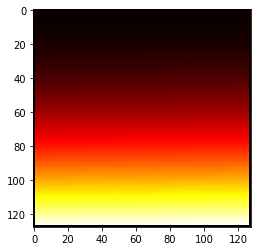

4096
28.924018383026123
1000


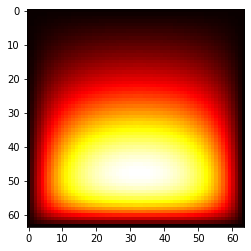

1024
21.50834059715271
3530


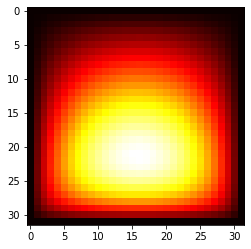

256
1.752291202545166
1399


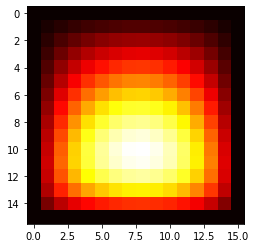

64
0.10878515243530273
414


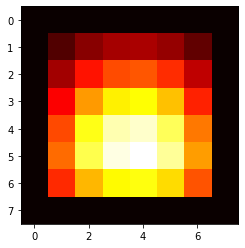

[0.         0.         0.         0.         0.         0.40747275
 0.51735956 0.         0.         0.78264992 0.96992768 0.
 0.         0.         0.         0.        ]
4
GOAL COUNT
14
16
                     Start prolognation to intermediate phase
0.00443577766418457
16
92


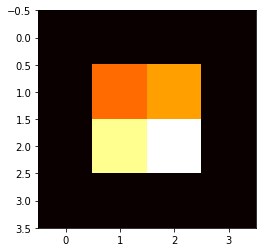

64
0.10143399238586426
64
391


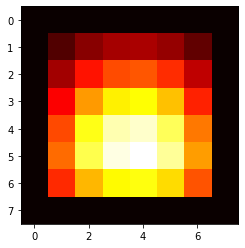

256
                   Start restriction from intermediate phase to minimum COARSE phase
256
2.3110194206237793
1798


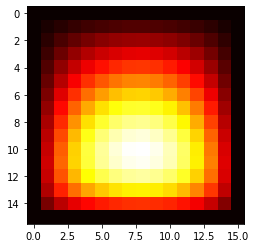

64
0.14325976371765137
523


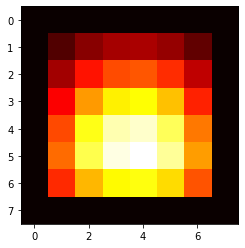

                   Start prolongation from minimum COARSE phase to FINE grid
0.0027894973754882812
16
92


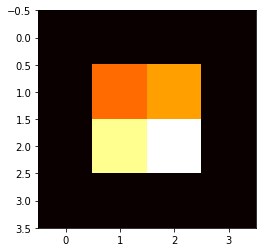

64
0.0996849536895752
64
391


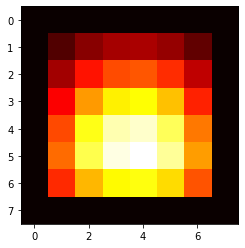

256
1.6556086540222168
256
1296


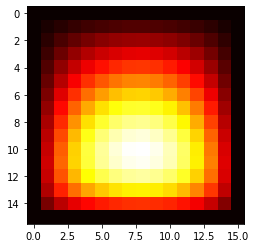

1024
6.074995756149292
1024
1000


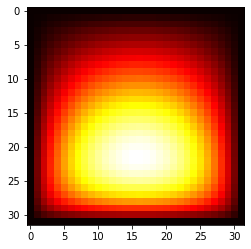

4096
0.025865554809570312
4096
1


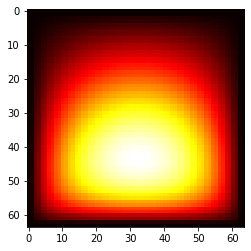

16384
6469.185967206955
16384
57738


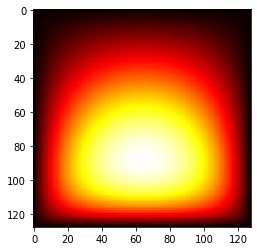

16384
W_MultiGrid Took
6546.728039741516
Number of equivalent iterations on the FINE GRID
58349.47265625


In [152]:
x = w_multigrid(u, min=4, intermediate=6,  omega=0.6, sig=1, sor=0, mode=1)

12
         Start restriction
4096
0.026025772094726562
1


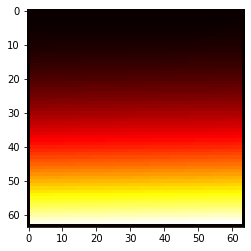

1024
6.1778504848480225
1000


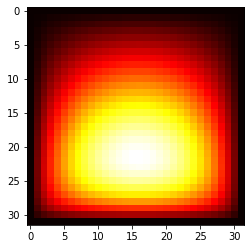

256
1.2906444072723389
1000


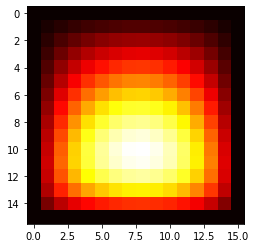

64
0.15435171127319336
575


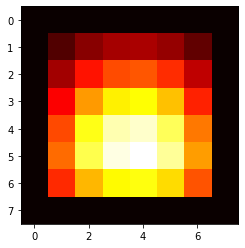

[0.         0.         0.         0.         0.         0.40747275
 0.51735956 0.         0.         0.78264992 0.96992768 0.
 0.         0.         0.         0.        ]
4
GOAL COUNT
12
16
         Start prolognation
0.0023970603942871094
16
73


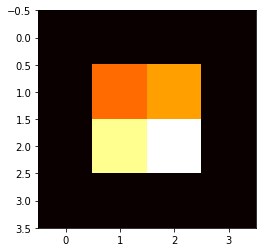

64
0.09755802154541016
64
391


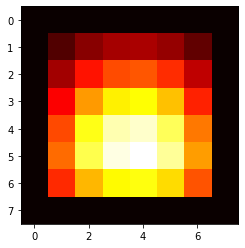

256
1.2795956134796143
256
1000


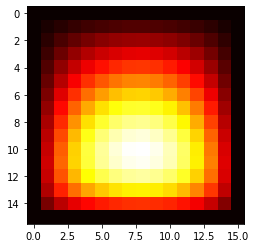

1024
6.079994440078735
1024
1000


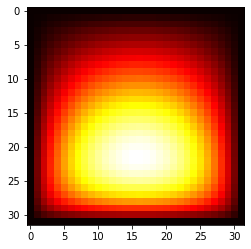

4096
376.4861307144165
4096
13954


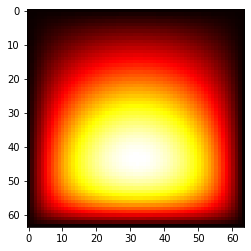

4096
V_MultiGrid Took
393.67645144462585
Number of equivalent iterations on the FINE GRID
14595.37890625


In [141]:
x = v_multigrid(u, min=4,  omega=0.6, sig=1, sor=0, mode=1)

Conventional SOR exclusively on the FINE grid took
87.98614287376404


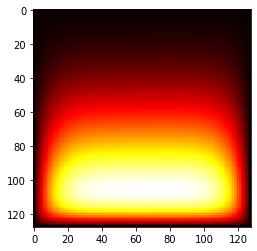

In [24]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n)
A = fivediag(N, n ,h, 0)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_SOR(A,f,u,0.6,1e-6,800)
plot_heatmap(u2)

In [25]:
d

[0.21018535536836083,
 0.20686234027668615,
 0.20356589342323583,
 0.20237311688600956,
 0.20006938228391802,
 0.1994883692191396,
 0.1985187415001588,
 0.1971416088789344,
 0.1961858798173879,
 0.19558666140472059,
 0.19481744436343584,
 0.19388716291311914,
 0.1928024156368675,
 0.19234978981955253,
 0.19182432228023094,
 0.19121105513925407,
 0.19052204022137786,
 0.18976356281401952,
 0.1890290549120639,
 0.18862386211095306,
 0.18817928433911169,
 0.18768959118916584,
 0.18715635130811137,
 0.18658186888061046,
 0.1859774392359821,
 0.18536964227061148,
 0.18501961041256187,
 0.1846417159915923,
 0.18424063789282386,
 0.18381797715416415,
 0.18337190392054925,
 0.18290361275315714,
 0.18241430383512647,
 0.18190989082669162,
 0.18151630890185544,
 0.1812001418027398,
 0.18086799491314487,
 0.1805204275047032,
 0.1801607217914185,
 0.1797895301598098,
 0.17940538416737528,
 0.17900890154214988,
 0.17860069003305146,
 0.1781814142420277,
 0.177836839775674,
 0.17755985153068643,
 0.

In [19]:
yt = restrict_injection

In [20]:
x=yt(u)

In [21]:
x.size

1024

In [22]:
u.size

4096